In [30]:
# Import Necessary Libraries
import numpy as np
from numpy import dtype
import scipy.ndimage
import netCDF4 as nc
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import scipy as scipy
from scipy import stats,signal
from datetime import date
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import cartopy.io.shapereader as shpreader
import cftime
import pingouin as pg
import csv
import os
import glob
import dask

/tmp/ipykernel_15331/3479049209.py:8: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


In [2]:
from dask.distributed import Client
# Try setting up a port using -L to get the dashboard to work
client = Client()  # set up local cluster on your machine
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 128.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38663,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 128.00 GiB
Comm: tcp://127.0.0.1:32793,Total threads: 1
Dashboard: http://127.0.0.1:36825/status,Memory: 32.00 GiB
Nanny: tcp://127.0.0.1:44293,


In [3]:
import xarray as xr
import gcsfs

# --- Connect to GCS anonymously ---
fs = gcsfs.GCSFileSystem(token='anon')

# --- Define desired variables ---
vars_to_load = ["geopotential"]

# --- Define time and spatial constraints ---
time_slice = slice("1990-01-01", "2024-12-31")
level_slice = 500
lat_slice = slice(55, 24)   
lon_slice = slice(230, 300)

# --- Open only desired variables with lazy indexing ---
store = fs.get_mapper(
    "gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3"
)

# Using consolidated metadata improves speed significantly
ds = xr.open_zarr(
    store,
    consolidated=True,
    chunks={},  # don't override chunks at open; let Zarr metadata guide it
)

# --- Now apply subset *before* Dask builds the full graph ---
# This ensures Dask only touches warm-season + desired region/time data
ds = ds[vars_to_load].sel(
    time=time_slice,
    latitude=lat_slice,
    longitude=lon_slice,
    level=level_slice
)

# --- Filter hours and months efficiently ---
ds = ds.sel(time=ds.time.dt.hour.isin([0, 3, 6, 9, 12, 15, 18, 21]))

ds = ds.persist()

 --- Rechunk AFTER slicing ---
 Only rechunk now, once the dataset is small enough to handle efficiently
ds = ds.chunk({
    "time": 976,         # about 10 days per chunk (~ manageable)
    "latitude": 125,     # full lat span in your region
    "longitude": 281,    # full lon span in your region
})

ds

/data/keeling/a/mgraber2/miniconda3/lib/python3.9/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.38.0 or higher is recommended. You are running version 2.36.0
  warnings.warn(
/tmp/ipykernel_56332/2692078264.py:22: UserWarning: Failed to load chunk manager entrypoint dask due to No module named 'xarray.core.daskmanager'. Skipping.
  ds = xr.open_zarr(


<xarray.Dataset> Size: 2GB
Dimensions:       (time: 17528, latitude: 125, longitude: 281)
Coordinates:
  * latitude      (latitude) float32 500B 55.0 54.75 54.5 ... 24.5 24.25 24.0
    level         int64 8B 500
  * longitude     (longitude) float32 1kB 230.0 230.2 230.5 ... 299.8 300.0
  * time          (time) datetime64[ns] 140kB 1990-01-01 ... 1995-12-31T21:00:00
Data variables:
    geopotential  (time, latitude, longitude) float32 2GB dask.array<chunksize=(1, 125, 281), meta=np.ndarray>
Attributes:
    valid_time_start:       1940-01-01
    last_updated:           2025-12-03 01:47:52.697060+00:00
    valid_time_stop:        2025-08-31
    valid_time_stop_era5t:  2025-11-27

In [4]:
# Take out unnecessary coordinates
ds = ds.drop_vars('level')

In [5]:
# Calculate daily mean geopotential heights
geopotential = ds['geopotential'].astype('float32')
Z = geopotential/9.80665
Z_mean = Z.resample(time="1D").mean()
Z_mean = Z_mean.persist()
Z_mean

<xarray.DataArray 'geopotential' (time: 2191, latitude: 125, longitude: 281)> Size: 308MB
dask.array<stack, shape=(2191, 125, 281), dtype=float32, chunksize=(1, 125, 281), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 500B 55.0 54.75 54.5 54.25 ... 24.5 24.25 24.0
  * longitude  (longitude) float32 1kB 230.0 230.2 230.5 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 18kB 1990-01-01 1990-01-02 ... 1995-12-31

In [7]:
Z_mean = Z_mean.chunk({
    "time": 365
})

Z_mean

<xarray.DataArray 'geopotential' (time: 2191, latitude: 125, longitude: 281)> Size: 308MB
dask.array<rechunk-merge, shape=(2191, 125, 281), dtype=float32, chunksize=(365, 125, 281), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 500B 55.0 54.75 54.5 54.25 ... 24.5 24.25 24.0
  * longitude  (longitude) float32 1kB 230.0 230.2 230.5 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 18kB 1990-01-01 1990-01-02 ... 1995-12-31

In [8]:
Z_mean = Z_mean.compute()

In [3]:
# Save Z_mean for future use
Z_mean.to_netcdf('/data/keeling/a/mgraber2/Course scripts/ATMS523/Module8/ATMS523_500H.nc')

## We need to follow a method similar to Lee et al. 2023. This will allow for summertime days having the same magnitude.
An excerpt from Lee et al. 2023: "Finally, following a similar method to Grams et al. (2017), we normalize by the seasonal cycle in the variance of the Z500 anomalies. The standard deviation of Z500 anomalies across 1979–2022 is computed for each day of the year at each grid point in the regime domain, and then area-averaged with a cosine-latitude weighting. Then, a 60-day centered running mean is applied, and the Z500 anomalies are divided by this scalar as a function of calendar day (Fig. 1d)."

In [8]:
# Load the nc file containing the data
H500 = xr.open_dataset('ATMS523_500H.nc')
H500

<xarray.Dataset> Size: 2GB
Dimensions:    (latitude: 125, longitude: 281, time: 12053)
Coordinates:
  * latitude   (latitude) float64 1kB 55.0 54.75 54.5 54.25 ... 24.5 24.25 24.0
  * longitude  (longitude) float64 2kB -130.0 -129.8 -129.5 ... -60.25 -60.0
  * time       (time) datetime64[ns] 96kB 1990-01-01 1990-01-02 ... 2022-12-31
Data variables:
    z          (time, latitude, longitude) float32 2GB ...

In [13]:
#define the latlon domain and the time period
lat1=24;lat2=55
lon1=230;lon2=300
iyr1=1990; iyr2=2022
nyr=iyr2-iyr1+1
dt01='-01-01';dt02='-02-28'
dt03='-03-01';dt12='-12-31'	#neglect leap years
ndy=(date(1979,12,31)-date(1979,1,1)).days +1
years = np.arange(iyr1, iyr2+1)

In [10]:
# Convert longitude to the 0-360 scale
H500['longitude'] = xr.where(H500['longitude'] < 0, H500['longitude'] + 360, H500['longitude'])
H500 = H500.sortby(H500.longitude)

# Define additional H500 variable so that you can slice among January-February and March-December
H500_1 = H500

In [11]:
#read daily 500H from 1990-2022
#note that the latitude dimension is reversed
for iyr in range(iyr1,iyr2+1):
   #read January and February in Year(0)
   tm1=str(iyr)+dt01 
   tm2=str(iyr)+dt02 
   hgt0=H500.z.sel(time=slice(tm1,tm2),longitude=slice(lon1,lon2),latitude=slice(lat2,lat1))

   #read March-December
   tm1=str(iyr)+dt03 
   tm2=str(iyr)+dt12 
   hgt1=H500_1.z.sel(time=slice(tm1,tm2),longitude=slice(lon1,lon2),latitude=slice(lat2,lat1))
   hgt01=xr.concat([hgt0, hgt1],dim='time')
   if iyr==iyr1:	#initialize hgt and extract latlon info
       lats=hgt01['latitude'].values;
       lons=hgt01['longitude'].values;
       nn,nlat,nlon=hgt01.shape
       heights=np.zeros((nyr,ndy,nlat,nlon))

   heights[iyr-iyr1,:,:,:]=hgt01.rolling(time=5,center=True,min_periods=1).mean()
print('Finish reading H500')
hgt2=heights[0]

Finish reading H500


In [12]:
# Remove the seasonal cycle, the 33-year running mean, on each calendar day
anomalies=heights-np.mean(heights, axis=0)

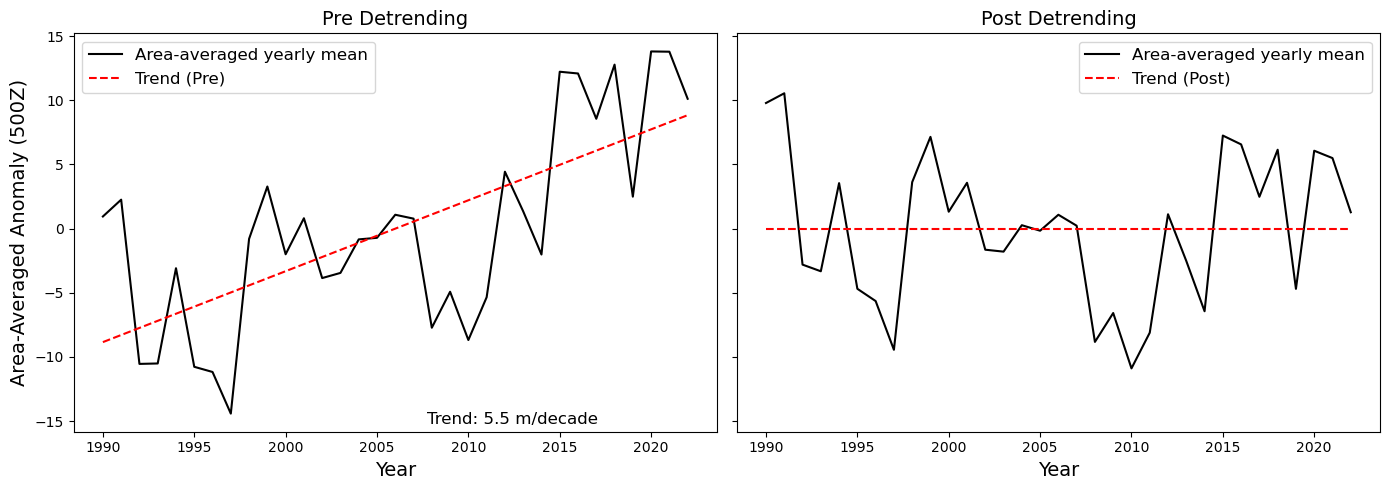

In [20]:
# Compute the area-averaged yearly mean
# Fit the yearly trend
# Compute the slope of the linear trend in m/decade
yearlyarea_mean = anomalies.mean(axis=(1, 2, 3))
coeffs = np.polyfit(years, yearlyarea_mean, 1)
trend_decade = coeffs[0] * 10
trend = np.polyval(coeffs, years)

# remove the yearly area-averaged linear trend from the anomalies
trend_reshaped = trend[:, None, None, None]   # shape (33,1,1,1)

detrended_anoms = anomalies - trend_reshaped

# Make a two-panel plot of yearly area-averaged anomalies pre- and post-detrending
yearly_mean_dt = detrended_anoms.mean(axis=(1,2,3))
trend_before = trend
trend_after = np.polyval(np.polyfit(years, yearly_mean_dt, 1), years)

fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Pre detrending
ax[0].plot(years, yearlyarea_mean, 'k-', label="Area-averaged yearly mean")
ax[0].plot(years, trend_before, 'r--', label="Trend (Pre)")
ax[0].set_title("Pre Detrending", fontsize=14)
ax[0].set_xlabel("Year", fontsize=14)
ax[0].set_ylabel("Area-Averaged Anomaly (500Z)", fontsize=14)
ax[0].legend(fontsize=12)

# Add the slope in m/decade
ax[0].text(
    0.55, 0.05,
    f"Trend: {trend_decade:.1f} m/decade",
    transform=ax[0].transAxes,
    fontsize=12,
    verticalalignment="top"
)

# Post detrending
ax[1].plot(years, yearly_mean_dt, 'k-', label="Area-averaged yearly mean")
ax[1].plot(years, trend_after, 'r--', label="Trend (Post)")
ax[1].set_title("Post Detrending", fontsize=14)
ax[1].set_xlabel("Year", fontsize=14)
ax[1].legend(fontsize=12)

plt.tight_layout()
plt.show()

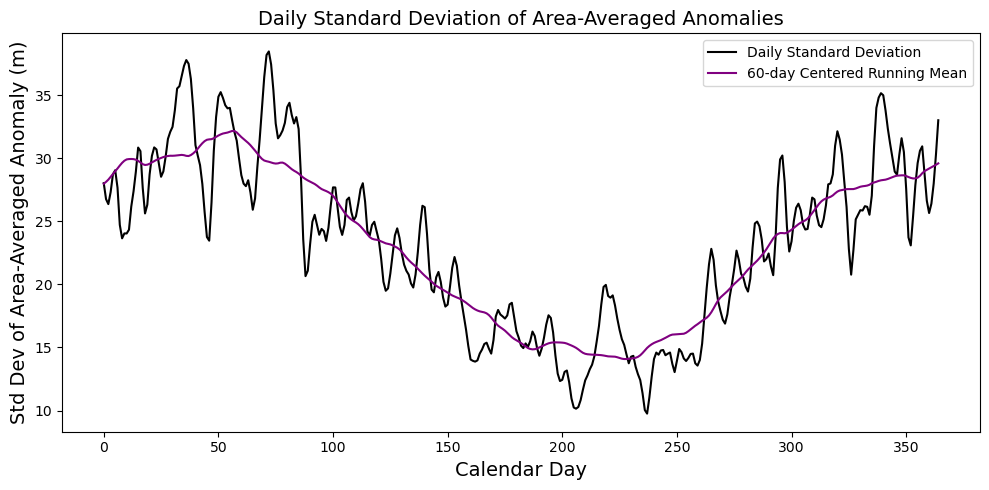

In [24]:
# Compute area-averaged anomalies for each day every year
# Compute the standard deviation on each calendar day across all years
# Compute a 60-day centered running mean of the standard deviation
area_anoms = detrended_anoms.mean(axis=(2, 3))
daily_std = area_anoms.std(axis=0)
rm60 = pd.Series(daily_std).rolling(60, center=True, min_periods=1).mean()
rm60 = rm60.values

# Plot the daily std and the 60-day running mean
plt.figure(figsize=(10,5))

plt.plot(daily_std, label="Daily Standard Deviation", color="black")
plt.plot(rm60, label="60-day Centered Running Mean", linestyle="-", color="purple")

plt.xlabel("Calendar Day", fontsize=14)
plt.ylabel("Std Dev of Area-Averaged Anomaly (m)", fontsize=14)
plt.title("Daily Standard Deviation of Area-Averaged Anomalies", fontsize=14)
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

In [25]:
# Normalize the anomalies by the 60-day centered running mean
rm60_reshaped = rm60[None, :, None, None]
normalized_anoms = detrended_anoms / rm60_reshaped

In [27]:
#calculate a cosine weighting function
lon2d,lat2d=np.meshgrid(lons,lats)
wgt=np.cos(lat2d*np.pi/180.0)
wgts=np.repeat(wgt[np.newaxis,:],nyr*ndy,axis=0)

In [28]:
#reshape the data to [ny*nday, nlon*nlat]
hgt0=np.reshape(normalized_anoms,(nyr*ndy,nlat,nlon))	#un-weighted H500
wgts=np.reshape(wgts,(nyr*ndy,nlat*nlon))
anoms=np.reshape(normalized_anoms,(nyr*ndy,nlat*nlon))
anoms=anoms*wgts

In [31]:
from eofs.standard import Eof
# Apply an EOF filter
solver = Eof(anoms)

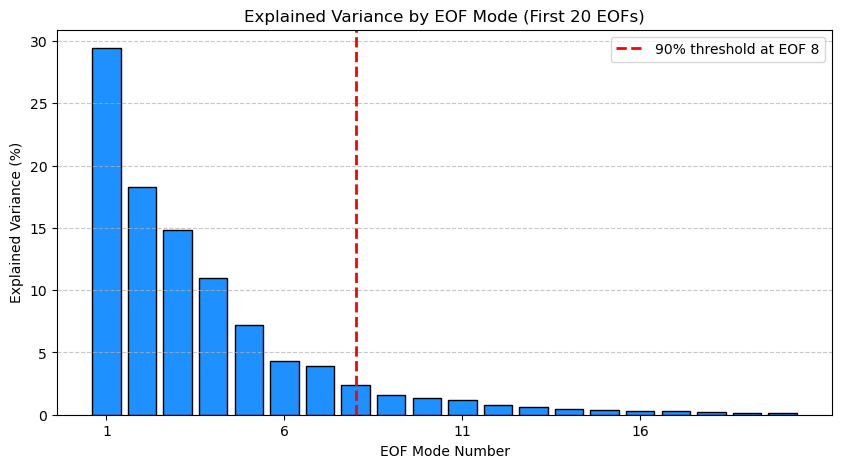

90% variance reached at EOF mode: 8


In [32]:
# Compute variance fractions
variance_fraction = solver.varianceFraction()      
variance_fraction_percent = variance_fraction[:20] * 100

# Compute cumulative variance
cumulative_variance = np.cumsum(variance_fraction) * 100 

# Find EOF mode where cumulative variance first exceeds 90%
mode_90 = np.argmax(cumulative_variance >= 90) + 1 

# Plot
plt.figure(figsize=(10, 5))
plt.bar(range(1, 21), variance_fraction_percent,
        color='dodgerblue', edgecolor='black')

# Add vertical dashed red line
plt.axvline(mode_90, color='red', linestyle='--', linewidth=2,
            label=f"90% threshold at EOF {mode_90}")

# Labels and title
plt.xlabel("EOF Mode Number")
plt.ylabel("Explained Variance (%)")
plt.title("Explained Variance by EOF Mode (First 20 EOFs)")
plt.xticks(range(1, 21, 5))
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()

plt.show()

print(f"90% variance reached at EOF mode: {mode_90}")


In [33]:
# Retain the first 8 EOFs accounting for ~90% of the variance
n_eofs = 8
pc_scores = solver.pcs(npcs=n_eofs, pcscaling=1)  # Principal Component scores
eof_modes = solver.eofs(neofs=n_eofs)  # Spatial EOFs
eigenvalues = solver.eigenvalues()[:n_eofs]  # First 20 eigenvalues

# Scale EOFs by the square root of eigenvalues
eof_modes_scaled = eof_modes * np.sqrt(eigenvalues[:, np.newaxis])

# Reconstruct the filtered dataset
heights_eof_filtered = np.tensordot(pc_scores, eof_modes_scaled, axes=(1, 0))

# Check variance again
print("Fixed EOF-Filtered Data Variance:", np.var(heights_eof_filtered))

Fixed EOF-Filtered Data Variance: 3.5798383901544617


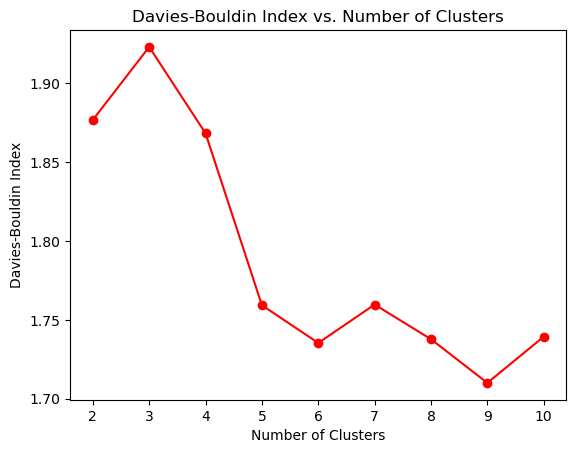

In [34]:
from sklearn.metrics import davies_bouldin_score

# Determine the proper number of clusters for K-means clustering using the Davies-Bouldin Index
dbi_scores = []
K = range(2, 11)  
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=20).fit(heights_eof_filtered)
    labels = kmeans.labels_
    dbi_scores.append(davies_bouldin_score(heights_eof_filtered, labels))

# Plot DBI scores
plt.plot(K, dbi_scores, 'ro-')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index vs. Number of Clusters')
plt.show()

In [35]:
#apply the k-mean cluster analysis for n=5 clusters
from sklearn.cluster import KMeans
km_standard = KMeans(n_clusters=5,random_state=0, n_init=20).fit(heights_eof_filtered)
labels = km_standard.labels_ 		#of the dimension (nyr*ndy)
WR0 = km_standard.cluster_centers_	#cluster centers
WR0 = np.reshape(WR0,(5,nlat,nlon))

In [36]:
# Define a function for rearranging the labels array to ensure 0-4 go from highest the least frequent
def rearrange_by_frequency(array):
    # Count the occurrences of each unique value
    unique, counts = np.unique(array, return_counts=True)
    freq_map = dict(zip(unique, counts))
    
    # Sort unique values by descending frequency
    sorted_values = sorted(freq_map.keys(), key=lambda x: freq_map[x], reverse=True)
    
    # Create a mapping where the most frequent gets 0, second most gets 1, etc.
    mapping = {old_val: new_val for new_val, old_val in enumerate(sorted_values)}
    
    # Apply the mapping to the array
    rearranged_array = np.vectorize(mapping.get)(array)
    return rearranged_array, mapping

In [38]:
# Call the function to create the rearranged array
rearranged_array, mapping = rearrange_by_frequency(labels)

In [40]:
# Save the rearranged labels file
save = '/data/keeling/a/mgraber2/Course scripts/ATMS523/Module8/'
np.save(f'{save}labels.npy', rearranged_array)

In [42]:
# Calculate the annual frequency
# Calculate the cluster freq.

length = len(labels)
years=[]
anncounts = []

# Divide labels into years
for x in range(int(length / 365)):
    yearly_labels = rearranged_array[x * 365:(x + 1) * 365]
    years.append(yearly_labels)
    
    # Count occurrences of each regime for this year
    regimes, counts = np.unique(yearly_labels, return_counts=True)
    
    # Initialize count array with zeros for all 5 regimes
    count_array = np.zeros(5, dtype=int)
    
    # Place the counts in the correct positions according to regime labels
    count_array[regimes] = counts
    
    # Append the counts to the list
    anncounts.append(count_array)

# Convert to a NumPy array for easier manipulation
anncounts_array = np.array(anncounts)

# Now, extract counts for each regime correctly
anncountswr1 = anncounts_array[:, 0]  
anncountswr2 = anncounts_array[:, 1]  
anncountswr3 = anncounts_array[:, 2]  
anncountswr4 = anncounts_array[:, 3]  
anncountswr5 = anncounts_array[:, 4]  

# Calculate unique counts and frequencies
unique, counts = np.unique(rearranged_array, return_counts=True)
freq = np.round(100.0 * counts / len(rearranged_array), 1)

# Combine all lists into a 2D NumPy array
anncounts_final = np.array([anncountswr1, anncountswr2, anncountswr3, anncountswr4, anncountswr5]).T

In [43]:
# Save the annual frequency file for later use
np.save(f'{save}annualcounts.npy', anncounts_final)

In [44]:
#calculate the cluster mean using un-weighted data
WRs=np.zeros((5,nlat,nlon)) 
for i in unique:
    D=np.where(rearranged_array==i)
    WRs[i]=np.nanmean(hgt0[D],axis=0)

In [45]:
#order WRs with descending freq. by multiplying -1.0
ii=np.argsort(-1.0*freq)
freq=freq[ii]
WRs=WRs[ii]

In [47]:
#relabel
ll=np.copy(rearranged_array)
for i in range(5):
   rearranged_array[ll==ii[i]]=i

In [48]:
# Save the WR structures
np.save(f'{save}WR_structures.npy', WRs)

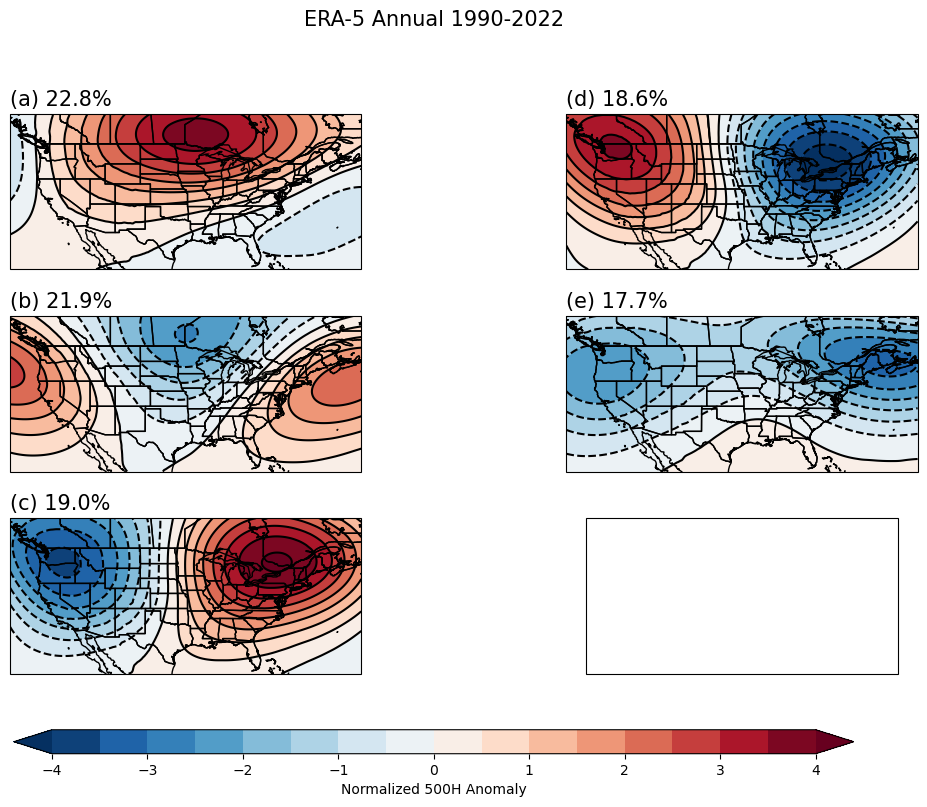

Normal End!


In [55]:
import cartopy.crs as ccrs
import cartopy.feature as cf
import cartopy.mpl.ticker as cticker

# plot each regime
mode_name=['(a)','(b)','(c)','(d)', '(e)']
fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(12,8),
    subplot_kw={'projection': ccrs.PlateCarree()})

axes=axes.T.flat
for kk in range(5):
    axx=axes[kk]
    levels=np.arange(-4,4.1,0.5)
    im0 = axx.contourf(lon2d,lat2d,WRs[kk],levels,cmap = plt.get_cmap('RdBu_r'),extend='both')
    im1 = axx.contour(lon2d,lat2d,WRs[kk],levels,colors='k')
 
    axx.coastlines()
    axx.set_title(mode_name[kk]+' '+str(freq[kk])+'%',fontsize=15,loc='left')
    axx.add_feature(cf.BORDERS)
    axx.add_feature(cf.STATES)
    kk=kk+1
plt.suptitle('ERA-5 Annual 1990-2022',fontsize=15,y=0.98)
fig.tight_layout()
plt.subplots_adjust(top=0.85,bottom=0.15,left=0.10,right=0.95,hspace=0.3,
wspace=0.20)
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.03]) # left, bottom height ,length, width
fig.colorbar(im0,orientation='horizontal',cax=cbar_ax, label='Normalized 500H Anomaly')
fmt="png"
plt.savefig(f'{save}WRs_figure.'+fmt,format=fmt,bbox_inches='tight')
plt.show(block=False)
print('Normal End!') 

In [60]:
np.shape(years)

(33, 365)

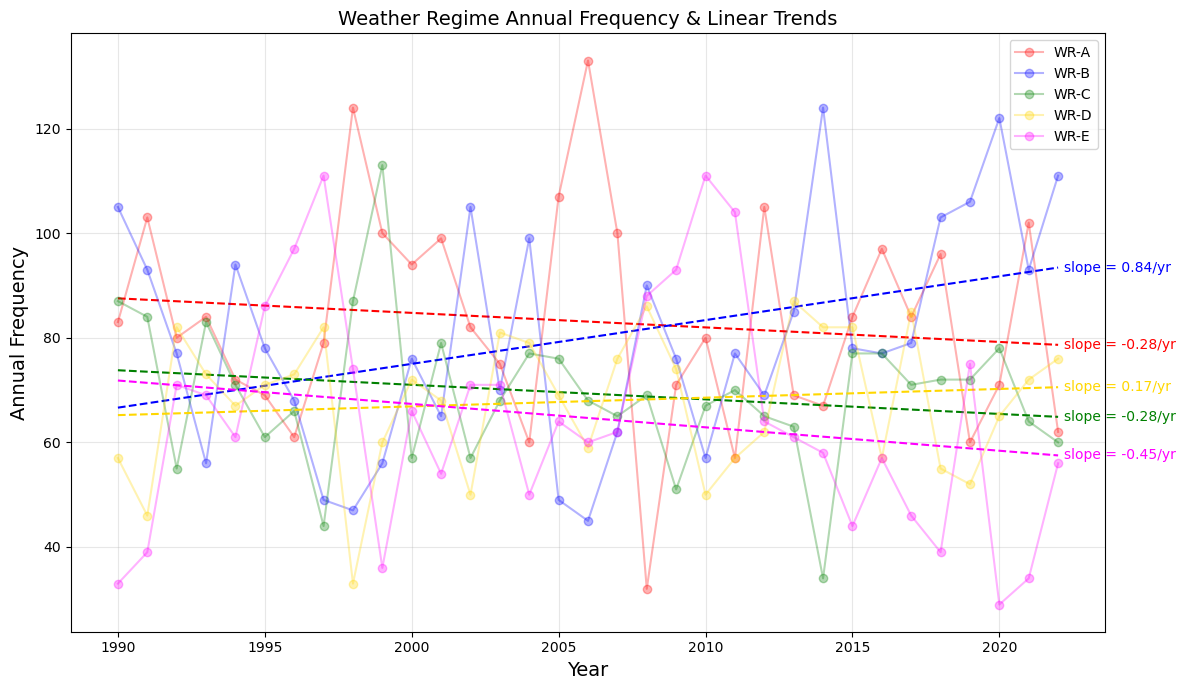

In [63]:
from scipy.stats import linregress
# Plot the long-term frequency of each WR
plt.figure(figsize=(12, 7))
colors = ['red', 'blue', 'green', 'gold', 'magenta']
labels = ['WR-A', 'WR-B', 'WR-C', 'WR-D', 'WR-E']
years = np.arange(iyr1, iyr2+1)

for i in range(5):
    ts = anncounts_final[:, i]

    # Plot actual time series
    plt.plot(years, ts, marker='o', color=colors[i], label=labels[i], alpha=0.3)

    # Linear regression
    slope, intercept, r, p, se = linregress(years, ts)

    # Plot trend line
    plt.plot(years, intercept + slope * years, linestyle='--', color=colors[i], alpha=1)

    # Add slope text
    plt.text(
        years[-1] + 0.2,                 # slightly right of last year
        intercept + slope * years[-1],   # trend line value at last year
        f"slope = {slope:.2f}/yr",
        color=colors[i],
        va='center'
    )

plt.xlabel("Year", fontsize=14)
plt.ylabel("Annual Frequency", fontsize=14)
plt.title("Weather Regime Annual Frequency & Linear Trends", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()